In [1]:
from numpy import save,load
import keras 
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import random
import tensorflow as tf
import cv2

from keras import models
from keras import layers 
from keras.applications import ResNet50
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#SET UP DRIVE IN COLAB
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/CNN2/Eyes'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1uu4MCOdjfOx0BLZ5kH2wt4bVozidgPTq/CNN2/Eyes


In [0]:
#CODE TO READ IMAGES THAT ARE DIVIDED INTO 4 FOLDERS OPEN_RIGHT EYES OPEN_LEFT_EYES CLOSED_RIGHT_EYES CLOSED_LEFT_EYES 
closed_eye_x=[]
photoR=[]
photoL=[]
i=0
for filename in os.listdir('./data/closedRightEyes/'): #for each file in that directory
    print(filename)
    photoR=img_to_array(load_img('./data/closedRightEyes/'+filename)) #open it and make an array
    
    left='./data/closedLeftEyes/'+filename[:-5]+'L.jpg' #the files on the left_eye version are called the same
    photoL=img_to_array(load_img(left))
    closed_eye_x.append(photoR) #add both eye_files to an array x
    closed_eye_x.append(photoL)
     #in case you want to read a finite amount of files
    #if(i==2):
    #  break
    i=i+1
    print(i)

closed_eye_x=np.array(closed_eye_x,dtype=float) #transform the X array into a numpy array shaped as [samples][y][x][channels]
save('./data/data_closed_eye_single_x.npy',closed_eye_x) #saves the array as a binary file to be easier to reload the dataset

open_eye_x=[]
photoR=[]
photoL=[]
i=0         #Same code as above but repeated for the open versions of eyes
for filename in os.listdir('./data/openRightEyes/'):
    print(filename)
    photoR=img_to_array(load_img('./data/openRightEyes/'+filename))
    
    left='./data/openLeftEyes/'+filename[:-5]+'L.jpg'
    photoL=img_to_array(load_img(left))
    open_eye_x.append(photoR)
    open_eye_x.append(photoL)
    #if(i==2):
    #  break
    i=i+1
    print(i)

open_eye_x=np.array(open_eye_x,dtype=float)
save('./data/data_open_eye_single_x.npy',open_eye_x)    #save as a binary file


In [0]:
closed_eye_x=load('../Face/data/data_closed_face_cropped_x.npy') #loads files from /Face/data/ which are the cropped eyes of full face images
open_eye_x=load('../Face/data/data_open_face_cropped_x.npy')

In [0]:
#CODE TO RESIZE ALL SAMPLES TO THE SAME SIZE NEEDS TO BE DUPLICATED FOR OPEN EYES AND CLOSED EYES
res=[]
temp=[]
images_shape=(64,64)
for i in range(len(closed_eye_x)):
  res= cv2.resize(closed_eye_x[i],(images_shape[1],images_shape[0]))
  temp.append(res)
closed_eye_x=np.array(temp)

res=[]
temp=[]
for i in range(len(open_eye_x)):
  res= cv2.resize(open_eye_x[i],(images_shape[1],images_shape[0]))
  temp.append(res)
open_eye_x=np.array(temp)

res=[]
temp=[]

In [0]:
#SPLITING THE DATA INTO DIFERENT PARTS FOR TRAINING VALIDATION AND TESTING
split2=int(closed_eye_x.shape[0]*0.2)   #SIZE FOR VALIDATION SET
split1=int(closed_eye_x.shape[0]*0.1)   #SIZE FOR TESTING SET

X=[]
closed_eye_x_validation=[]
closed_eye_x_testing=[]
#Dividing closed eye
closed_eye_x_testing=closed_eye_x[:split1]
closed_eye_x_validation=closed_eye_x[split1:split2+split1]
closed_eye_x=closed_eye_x[split2+split1:]

#Dividing open eye
open_eye_x_testing=open_eye_x[:split1]
open_eye_x_validation=open_eye_x[split1:split2+split1]
open_eye_x=open_eye_x[split2+split1:]

#Creating the labels 
Y=[]
X=np.concatenate((closed_eye_x,open_eye_x),axis=0)
Y=np.concatenate(  (np.ones(shape=(closed_eye_x.shape[0]),dtype=float),np.zeros(shape=(open_eye_x.shape[0]),dtype=float))  ,axis=0 )
Y=Y.reshape((Y.shape+(1,)))

Y_val=[]
X_val=np.concatenate((closed_eye_x_validation,open_eye_x_validation),axis=0)
Y_val=np.concatenate(  (np.ones(shape=(closed_eye_x_validation.shape[0]),dtype=float),np.zeros(shape=(open_eye_x_validation.shape[0]),dtype=float))  ,axis=0 )
Y_val=Y_val.reshape((Y_val.shape+(1,)))

Y_test=[]
X_test=np.concatenate((closed_eye_x_testing,open_eye_x_testing),axis=0)
Y_test=np.concatenate((np.ones(shape=(closed_eye_x_testing.shape[0]),dtype=float),np.zeros(shape=(open_eye_x_testing.shape[0]),dtype=float))  ,axis=0 )
Y_test=Y_test.reshape((Y_test.shape+(1,)))

#Erasing the variables for memory purposes
closed_eye_x=[]
closed_eye_x_testing=[]
closed_eye_x_validation=[]
open_eye_x=[]
open_eye_x_testing=[]
open_eye_x_validation=[]
photoL=[]
photoR=[]
left=[]
i=0
filename=[]


In [0]:
#DATA GENERATORS FOR EACH SUBSET
val_datagen = ImageDataGenerator(1./255)
test_datagen=ImageDataGenerator(1./255)
train_datagen = ImageDataGenerator(featurewise_center=True,
							rescale = 1./255,
							rotation_range = 40,
              width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,)

In [0]:
#IMAGES FROM THE DATA GENERATORS
val_batches=val_datagen.flow(X_val,Y_val,shuffle=True)
train_batches=train_datagen.flow(X,Y,shuffle=True)
test_batches=test_datagen.flow(X_test,Y_test,shuffle=True)

In [0]:
#CNN FOR EYE FEATURE EXTRACTION AND CLASSIFICATION

start = keras.Input(shape=(32,32,3))
Conv1 =layers.Conv2D(64,(3,3),padding='same',activation='relu')(start)
Conv2 =layers.Conv2D(64,(3,3),padding='same',activation='relu')(Conv1)
Pool1 =layers.MaxPooling2D(pool_size=(2,2))(Conv2)

Conv3 =layers.Conv2D(128,(3,3),padding='same',activation='relu')(Pool1)
Conv4 =layers.Conv2D(128,(3,3),padding='same',activation='relu')(Conv3)
Pool2 =layers.MaxPooling2D(pool_size=(2,2))(Conv4)

Conv5 =layers.Conv2D(256,(3,3),padding='same',activation='relu')(Pool2)
Conv6 =layers.Conv2D(256,(3,3),padding='same',activation='relu')(Conv5)
Pool3 =layers.MaxPooling2D(pool_size=(2,2))(Conv6)

Flat =layers.Flatten()(Pool3)
Den1 =layers.Dense(4*4*256,activation='relu')(Flat)
Den2  =layers.Dense(256,activation='relu')(Den1)
Den3  =layers.Dense(1,activation='sigmoid')(Den2)

model=keras.Model(start,Den3)

safe_acc=[]
safe_val_acc=[]
safe_loss=[]
safe_val_loss=[]

In [15]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0   

In [0]:
initial_learning_rate=0.0001
model.compile(loss='binary_crossentropy',
						optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate,amsgrad=True),
						metrics=['acc'])

In [18]:

carpet='Entrance26'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./Trained Models/'+carpet+'/Checkpoints/Checkpoint_weight_2nd_{epoch:02d}_{loss:.2f}_{acc:.2f}_{val_loss:.2f}_{val_acc:.2f}_.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False,
		verbose=0
)
history = model.fit_generator(train_batches, 
				steps_per_epoch =105,  #3348 samples over 32 sized batches
				epochs =20, 
				validation_data= val_batches, 
				validation_steps = 28,
				#callbacks=[model_checkpoint_callback],
				) #890 samples over 32 size batches

Epoch 1/20
  2/105 [..............................] - ETA: 9s - loss: 0.6931 - acc: 0.5000 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


105/105 [==============================] - 6s 60ms/step - loss: 0.6662 - acc: 0.6045 - val_loss: 59.7012 - val_acc: 0.6539
Epoch 2/20
105/105 [==============================] - 6s 53ms/step - loss: 0.5903 - acc: 0.6789 - val_loss: 32.9514 - val_acc: 0.7416
Epoch 3/20
105/105 [==============================] - 6s 53ms/step - loss: 0.5214 - acc: 0.7416 - val_loss: 25.7949 - val_acc: 0.8067
Epoch 4/20
105/105 [==============================] - 6s 54ms/step - loss: 0.4556 - acc: 0.7879 - val_loss: 46.4835 - val_acc: 0.8472
Epoch 5/20
105/105 [==============================] - 6s 53ms/step - loss: 0.3498 - acc: 0.8471 - val_loss: 38.4902 - val_acc: 0.8584
Epoch 6/20
105/105 [==============================] - 6s 53ms/step - loss: 0.2686 - acc: 0.8907 - val_loss: 61.5380 - val_acc: 0.9191
Epoch 7/20
105/105 [==============================] - 6s 54ms/step - loss: 0.2277 - acc: 0.9083 - val_loss: 4.7240 - val_acc: 0.9022
Epoch 8/20
105/105 [==============================] - 6s 53ms/step - loss:

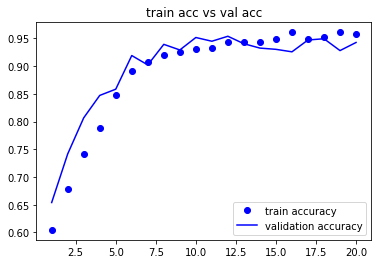

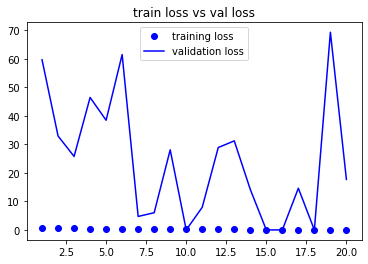

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



test acc :
 0.9516806602478027


In [19]:
#MODEL PLOTING AND SAVING OF WEIGHTS

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')

plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

test_loss, test_acc = model.evaluate_generator(test_batches, steps = 15)
print('\ntest acc :\n', test_acc)

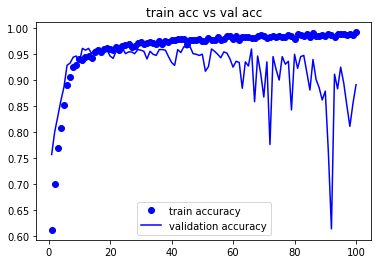

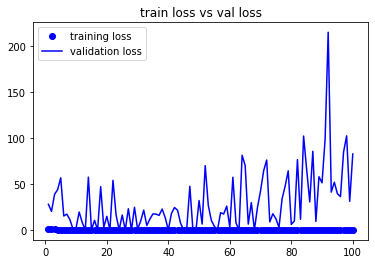

In [61]:
safe_acc=safe_acc+acc
safe_val_acc=safe_val_acc+val_acc
safe_loss=safe_loss+loss
safe_val_loss=safe_val_loss+val_loss

epochs = range(1, len(safe_acc)+1)

plt.plot(epochs,safe_acc,'bo',label='train accuracy')
plt.plot(epochs,safe_val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()
plt.savefig('./Trained Models/'+carpet+'/Accuracy_plot.png')
plt.figure()

plt.plot(epochs,safe_loss, 'bo', label ='training loss')
plt.plot(epochs,safe_val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.savefig('./Trained Models/'+carpet+'/Loss_plot.png')

In [42]:
#ARRAY SAVING; MODEL SAVING
save('./Trained Models/'+carpet+'/ACC.npy',safe_acc) 
save('./Trained Models/'+carpet+'/VACC.npy',safe_val_acc) 
save('./Trained Models/'+carpet+'/LOSS.npy',safe_acc) 
save('./Trained Models/'+carpet+'/VLOSS.npy',safe_acc)
model.save('./Trained Models/'+carpet+'/eye_detect.h5')

<Figure size 432x288 with 0 Axes>

lady.jpg
lady2.jpg
dude.jpg
dude2.jpg
dude4.jpg
lady3.jpg
0
Open


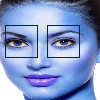

1
Open


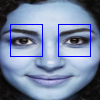

2
Open


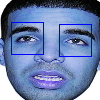

3
Open


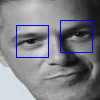

4
Closed


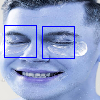

5
Closed


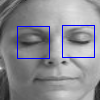

In [24]:
#!pip3 install mtcnn
from keras.models import load_model
from mtcnn.mtcnn import MTCNN
from google.colab.patches import cv2_imshow
carpet='Entrance26'

model.load_weights('/content/drive/My Drive/CNN2/Eyes/Trained Models/Entrance26/Checkpoints/Checkpoint_weight_49_0.06_0.98_0.00_0.95_.h5')
X=[]

for filename in os.listdir('../TryOut/'): #for each file in that directory
    print(filename)
    photo=img_to_array(load_img('../TryOut/'+filename))    
    X.append(photo)

cropped=[]
sq=16
detector=MTCNN()

temp=[]
for sample in range(len(X)):
    print(sample)
    temp_photo=np.array(X[sample])
    temp_faces=detector.detect_faces(temp_photo)
    faces=len(temp_faces)
    for i in range(faces):
      x=temp_faces[i]['box'][0]
      y=temp_faces[i]['box'][1]
      w=temp_faces[i]['box'][2]
      h=temp_faces[i]['box'][3]
      croppedFace=temp_photo[y:y+h,x:x+w,:]
      croppedFace=cv2.resize(croppedFace,(100,100))
      temp=detector.detect_faces(croppedFace)
      if(len(temp)!=0):
        x1,y1=temp[0]['keypoints']['left_eye']
        croppedL=croppedFace[y1-sq:y1+sq,x1-sq:x1+sq,:]
        x,y=temp[0]['keypoints']['right_eye']
        croppedR=croppedFace[y-sq:y+sq,x-sq:x+sq,:]
        croppedL=croppedL.reshape((1,32,32,3))
        croppedR=croppedR.reshape((1,32,32,3))
        if(model.predict(croppedL)==1):
          if(model.predict(croppedR)==1):
            print('Closed')
          else:
            print('Open')
        else:
          print('Open')
        croppedFace=cv2.rectangle(croppedFace,(x-sq,y-sq),(x+sq,y+sq),(255,0,0),(1))
        croppedFace=cv2.rectangle(croppedFace,(x1-sq,y1-sq),(x1+sq,y1+sq),(255,0,0),(1))
        cv2_imshow(croppedFace)


In [0]:
model.save('/content/drive/My Drive/CNN2/Eyes/Trained Models/'+carpet+'/Full_Model',include_optimizer=True)